<a href="https://colab.research.google.com/github/ShahidAfghan/hybrid-skin-lesion-classification/blob/main/final_hybrid_model_Skin_cancer_Multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Hybrid-Model-for-Skin-Disease-Classification-EfficientNetB0-and-ViT_Mycode

import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Force GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!pip install -q kaggle
!pip install opencv-python

from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle

!cp /content/drive/MyDrive/Colab_Notebooks/kaggle_API_TOKEN/kaggle.json ~/.kaggle/kaggle.json

! kaggle datasets download kmader/skin-cancer-mnist-ham10000

# dataset directory
import os
import zipfile


dataset_folder = 'dataset'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"Created '{dataset_folder}' directory")
# Unzip the dataset
zip_file_path = 'skin-cancer-mnist-ham10000.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
    print(f"Extracted all files to '{dataset_folder}' directory")


!ls -l

GPU available: True
GPU name: Tesla T4
Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.17G/5.20G [02:07<00:01, 15.4MB/s]
100% 5.20G/5.20G [02:07<00:00, 43.6MB/s]
Created 'dataset' directory
Extracted all files to 'dataset' directory
total 5452084
drwxr-xr-x 6 root root       4096 Jan 15 14:41 dataset
drwx------ 5 root root       4096 Jan 15 14:37 drive
drwxr-xr-x 1 root root       4096 Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 5582914511 Oct  6  2019 skin-cancer-mnist-ham10000.zip


In [ ]:
! ls -l dataset


total 130812
drwxr-xr-x 2 root root   167936 Jan 15 14:40 ham10000_images_part_1
drwxr-xr-x 2 root root   167936 Jan 15 14:40 HAM10000_images_part_1
drwxr-xr-x 2 root root   167936 Jan 15 14:41 ham10000_images_part_2
drwxr-xr-x 2 root root   167936 Jan 15 14:40 HAM10000_images_part_2
-rw-r--r-- 1 root root   563277 Jan 15 14:40 HAM10000_metadata.csv
-rw-r--r-- 1 root root 30807979 Jan 15 14:41 hmnist_28_28_L.csv
-rw-r--r-- 1 root root 91820383 Jan 15 14:41 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root  2537778 Jan 15 14:41 hmnist_8_8_L.csv
-rw-r--r-- 1 root root  7524968 Jan 15 14:41 hmnist_8_8_RGB.csv


In [ ]:
# required packages
!pip install torch torchvision torchmetrics pandas matplotlib seaborn scikit-learn Pillow opencv-python

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.7 MB/s eta 0:00:00


In [ ]:

import cv2
import numpy as np
from PIL import Image
from scipy import ndimage



def medical_optimized_apfb(image, hair_removal_strength=0.3):
    """
    Medical-optimized APFB - Preserves diagnostic features
    """
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)


    window_size = 11  # Smaller window
    percentile = 80   # Lower percentile


    kernel_size = max(3, int(hair_removal_strength * 7))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))


    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)


    _, hair_mask = cv2.threshold(blackhat, 15 * hair_removal_strength, 255, cv2.THRESH_BINARY)


    hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, kernel)


    contour_area_threshold = 50
    contours, _ = cv2.findContours(hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_hair_mask = np.zeros_like(hair_mask)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > contour_area_threshold:
            cv2.fillPoly(final_hair_mask, [contour], 255)

    inpainted = cv2.inpaint(image_np, final_hair_mask, 2, cv2.INPAINT_TELEA)


    mask_normalized = final_hair_mask.astype(np.float32) / 255.0
    mask_normalized = np.stack([mask_normalized] * 3, axis=-1)


    result = image_np * (1 - mask_normalized) + inpainted * mask_normalized
    result = result.astype(np.uint8)

    return Image.fromarray(result)

def adaptive_hair_removal_strategy(image):

    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()


    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(gray, 50, 150)
    hair_density = np.sum(edges > 0) / (gray.shape[0] * gray.shape[1])


    if hair_density < 0.05:
        strength = 0.1
    elif hair_density < 0.15:
        strength = 0.3
    else:
        strength = 0.5



    return medical_optimized_apfb(image, strength)


!pip install scikit-image

import cv2
import numpy as np
from scipy import ndimage
from skimage.util import view_as_windows


# "Analyzes image and returns the best scenario/settings"
def detect_image_scenario(image_np):

    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l_channel = lab[:, :, 0]

    # Calculate statistics
    avg_brightness = np.mean(l_channel)
    std_brightness = np.std(l_channel)

    # Detect hair density (using simple black hat)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    hair_density = np.count_nonzero(blackhat > 10) / blackhat.size

    # Detect lesion darkness (find darkest region)
    _, dark_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    dark_percentage = (np.count_nonzero(dark_mask) / dark_mask.size) * 100

    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.count_nonzero(edges) / edges.size

    lesion_pixels = gray[dark_mask > 0]
    hair_pixels = blackhat[blackhat > 10]

    # SCENARIO DETECTION LOGIC

    # Scenario 5: White skin (very bright)
    if avg_brightness > 180:
        return "White Skin", 7, 12, 0.4

    if dark_percentage > 15 and hair_density > 0.10:
        return "Black Hair in Lesion", 7, 12, 0.40

    if len(lesion_pixels) > 0 and len(hair_pixels) > 0:
        color_diff = abs(np.mean(lesion_pixels) - np.mean(hair_pixels))
        if color_diff < 15:
            return "Hair Color Similar to Lesion", 7, 12, 0.40

    if 140 < avg_brightness < 170 and hair_density > 0.07:
        return "Light Brown Hair", 7, 12, 2.20

    if hair_density > 0.05 and edge_density < 0.03:
        return "Very Thin Hair", 4, 12, 0.10

    if hair_density > 0.12 and edge_density > 0.08:
        return "Thick Long Hair", 10, 16, 0.40

    # Scenario 4: Black lesion without hair (dark + low hair density)
    if dark_percentage > 15 and hair_density < 0.05:
        return "Black Lesion (No Hair)", 7, 12, 0.4

    # Scenario 2: Long hair covering lesion (high hair density)
    if hair_density > 0.15:
        return "Long Hair Over Lesion", 7, 12, 1.5

    # Scenario 3: Light/medium brown with speckles (high texture variance)
    if std_brightness > 45 and 120 < avg_brightness < 160:
        return "Brown Lesion with Speckles", 3, 3, 0.05

    # Scenario
    return "Grey-Red Texture", 7, 12, 0.04



In [ ]:

# Set dataset paths
DATA_DIR = '/content/dataset/HAM10000_metadata.csv'
IMG_DIR_BASE = '/content/dataset'


print("Checking dataset files...")
print(f"Metadata exists: {os.path.exists(DATA_DIR)}")
print(f"Images part 1 exists: {os.path.exists('/content/dataset/ham10000_images_part_1')}")
print(f"Images part 2 exists: {os.path.exists('/content/dataset/ham10000_images_part_2')}")

# Load and prepare data
data = pd.read_csv(DATA_DIR)
print(f"Dataset shape: {data.shape}")
print(f"Class distribution:\n{data['dx'].value_counts()}")

# Mapping the diagnosis to numerical values
label_mapping = {
    'mel': 0, 'nv': 1, 'bkl': 2, 'bcc': 3,
    'akiec': 4, 'vasc': 5, 'df': 6,
}
data['dx_num'] = data['dx'].map(label_mapping)


Checking dataset files...
Metadata exists: True
Images part 1 exists: True
Images part 2 exists: True
Dataset shape: (10015, 7)
Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:

class SelectiveHairRemovalDataset(Dataset):
    def __init__(self, img_ids, labels, img_dir_base='/content/dataset',
                 transform=None, hair_removal_strategy='adaptive'):
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir_base = img_dir_base
        self.transform = transform
        self.hair_removal_strategy = hair_removal_strategy


        self.classes_for_hair_removal = ['mel', 'bcc', 'akiec']

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels[idx]
        label_name = list(label_mapping.keys())[label]

        # Find image path
        img_path = self._find_image_path(img_id)
        img = Image.open(img_path).convert('RGB')


        if label_name in self.classes_for_hair_removal:
            if self.hair_removal_strategy == 'adaptive':
                img = adaptive_hair_removal_strategy(img)
            elif self.hair_removal_strategy == 'medical':
                img = medical_optimized_apfb(img)

        if self.transform:
            img = self.transform(img)

        return img, label

    def _find_image_path(self, img_id):

        paths_to_check = [
            os.path.join(self.img_dir_base, 'ham10000_images_part_1', img_id + '.jpg'),
            os.path.join(self.img_dir_base, 'ham10000_images_part_2', img_id + '.jpg'),
            os.path.join(self.img_dir_base, 'HAM10000_images_part_1', img_id + '.jpg'),
            os.path.join(self.img_dir_base, 'HAM10000_images_part_2', img_id + '.jpg')
        ]

        for path in paths_to_check:
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"Image not found: {img_id}.jpg")

In [ ]:
# image augumentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Training samples: 8012
Validation samples: 2003
✅ Class imbalance handling added with WeightedRandomSampler
🔍 Quality Control Visualization:


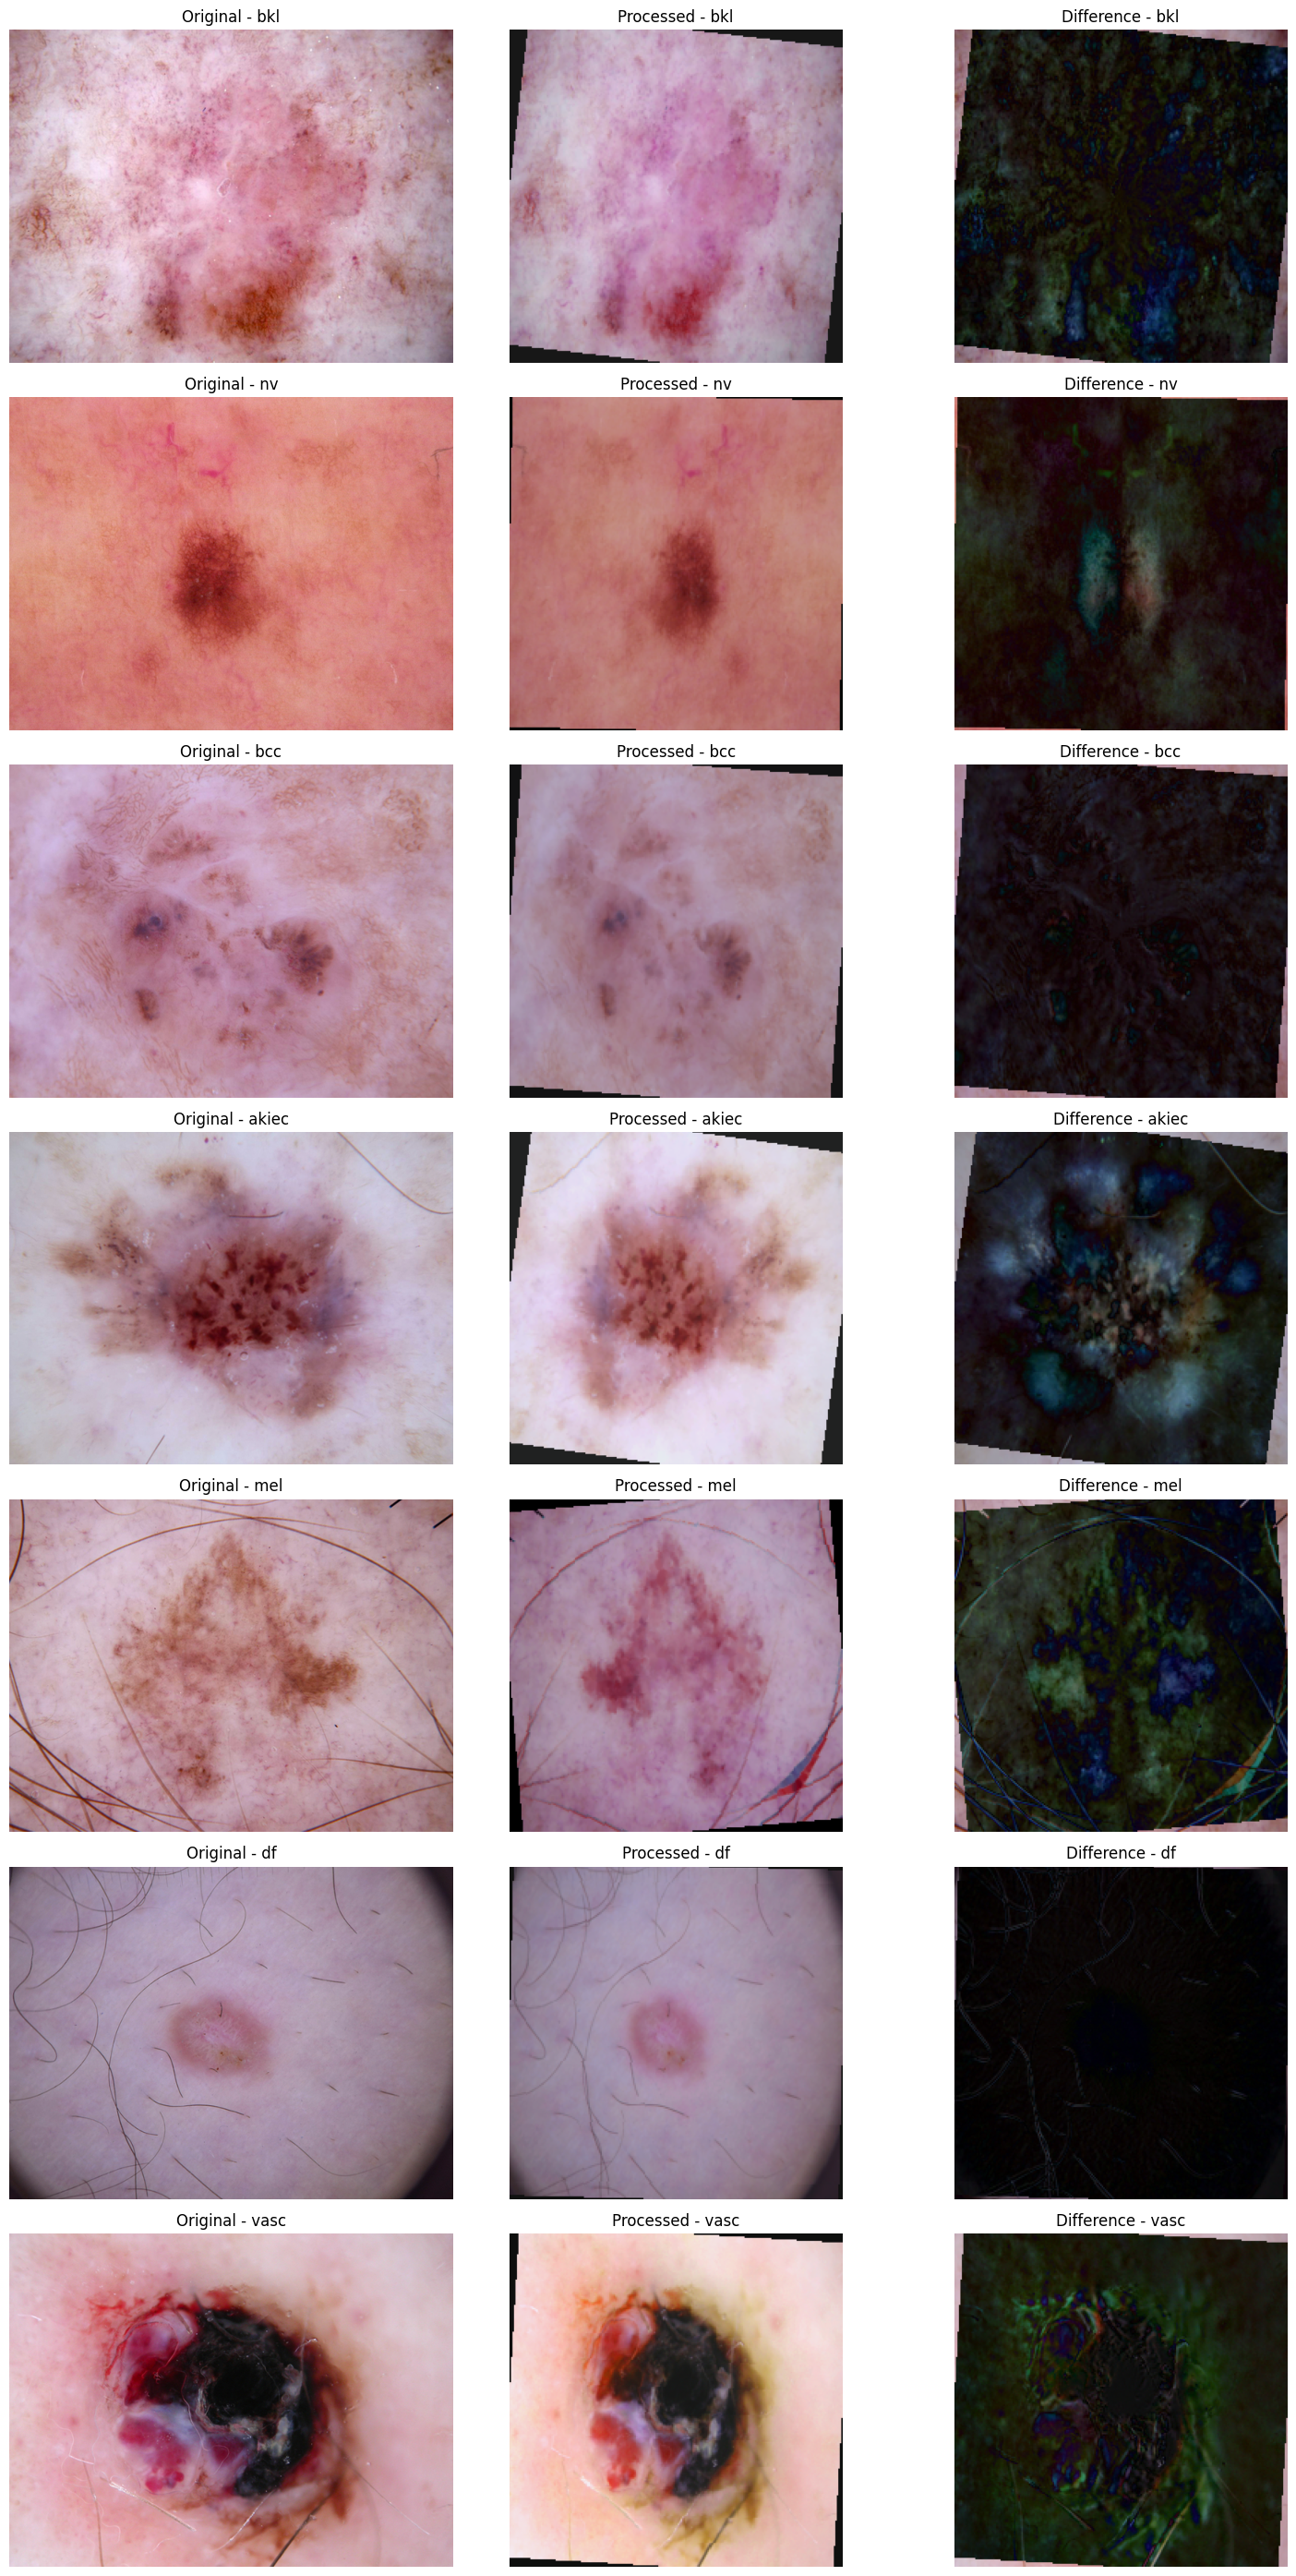

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    data['image_id'].values,
    data['dx_num'].values,
    test_size=0.2,
    stratify=data['dx_num'].values,
    random_state=42
)


print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


train_dataset = SelectiveHairRemovalDataset(
    X_train, y_train, transform=train_transform,
    hair_removal_strategy='adaptive'
)
val_dataset = SelectiveHairRemovalDataset(
    X_val, y_val, transform=val_transform,
    hair_removal_strategy='adaptive'
)



from torch.utils.data import WeightedRandomSampler

def create_balanced_sampler(dataset):

    class_counts = {}
    for _, label in dataset:
        label = label.item() if torch.is_tensor(label) else label
        class_counts[label] = class_counts.get(label, 0) + 1

    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label.item() if torch.is_tensor(label) else label]
                     for _, label in dataset]

    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


balanced_sampler = create_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=balanced_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("✅ Class imbalance handling added with WeightedRandomSampler")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



def quality_control_visualization(dataset, num_samples=6):

    class_samples = {}


    for i in range(len(dataset)):
        if len(class_samples) >= len(label_mapping):
            break

        _, label = dataset[i]
        label_name = list(label_mapping.keys())[label]

        if label_name not in class_samples:
            class_samples[label_name] = i

    fig, axes = plt.subplots(len(class_samples), 3, figsize=(15, 4*len(class_samples)))

    for idx, (class_name, sample_idx) in enumerate(class_samples.items()):
        # Original image
        img_id = dataset.img_ids[sample_idx]
        img_path = dataset._find_image_path(img_id)
        original_img = Image.open(img_path).convert('RGB')

        # Processed image
        processed_img, label = dataset[sample_idx]
        processed_img_np = processed_img.permute(1, 2, 0).numpy()
        processed_img_np = processed_img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        processed_img_np = np.clip(processed_img_np, 0, 1)

        # Difference
        original_resized = np.array(original_img.resize((224, 224))) / 255.0
        difference = np.abs(original_resized - processed_img_np)

        # Plot
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f'Original - {class_name}')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(processed_img_np)
        axes[idx, 1].set_title(f'Processed - {class_name}')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(difference)
        axes[idx, 2].set_title(f'Difference - {class_name}')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()


print("🔍 Quality Control Visualization:")
quality_control_visualization(train_dataset)



In [ ]:
# Hybrid model
class HybridSkinModel(nn.Module):
    def __init__(self, num_classes=7):
        super(HybridSkinModel, self).__init__()

        # Vision Transformer (ViT) part
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        vit_in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(vit_in_features, num_classes)

        # EfficientNet part
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.efficientnet.classifier[1] = nn.Linear(
            self.efficientnet.classifier[1].in_features, num_classes
        )

        # Combine the two models' output
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(
                self.vit.heads.head.out_features + self.efficientnet.classifier[1].out_features,
                num_classes
            )
        )

    def forward(self, x):
        vit_features = self.vit(x)
        efficientnet_features = self.efficientnet(x)
        combined = torch.cat((vit_features, efficientnet_features), dim=1)
        out = self.fc(combined)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class_counts = data['dx_num'].value_counts().sort_index()
total_samples = len(data)
class_weights = torch.tensor([total_samples / (len(class_counts) * count)
                             for count in class_counts], dtype=torch.float32).to(device)


criterion = FocalLoss(alpha=class_weights, gamma=2.0)
print("✅ Focal Loss added for class imbalance")

# .....................................................................................................................

model = HybridSkinModel(num_classes=len(label_mapping)).to(device)


print("Model Architecture:")
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)


Using device: cuda
✅ Focal Loss added for class imbalance
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:06<00:00, 51.2MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]


Model Architecture:
HybridSkinModel(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(

In [ ]:
===================================

from tqdm.auto import tqdm
import time

def train_model(model, train_loader, val_loader, num_epochs=25):
    best_val_accuracy = 0.0
    early_stopping_counter = 0
    patience = 5

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # progress bar
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0


        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (imgs, labels) in enumerate(train_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)


            current_loss = running_loss / (batch_idx + 1)
            current_acc = correct_preds / total_preds
            train_pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds


        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for imgs, labels in val_pbar:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels).item()
                total_preds += labels.size(0)

                # Update validation progress bar
                current_val_loss = val_loss / (len(val_pbar) * (val_pbar.n + 1) / len(val_loader))
                current_val_acc = correct_preds / total_preds
                val_pbar.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.4f}'
                })

        val_loss /= len(val_loader)
        val_accuracy = correct_preds / total_preds


        scheduler.step(val_loss)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'  ✅ Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'  🔍 Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_hybrid_model_apfb.pth')
            print(f'  💾 NEW BEST MODEL SAVED! Validation Accuracy: {val_accuracy:.4f}')
        else:
            early_stopping_counter += 1
            print(f'  ⏳ Early stopping counter: {early_stopping_counter}/{patience}')

        if early_stopping_counter >= patience:
            print(f'🛑 EARLY STOPPING triggered after {epoch+1} epochs!')
            break

        print('-' * 60)

    return train_losses, val_losses, train_accs, val_accs

# Start training
print("🚀 Starting Hybrid Model Training with APFB Hair Removal...")
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

🚀 Starting Hybrid Model Training with APFB Hair Removal...


Epoch 1/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/25 Summary:
  ✅ Train Loss: 0.9465, Train Accuracy: 0.7106
  🔍 Val Loss: 0.5338, Val Accuracy: 0.8372
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8372
------------------------------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/25 Summary:
  ✅ Train Loss: 0.6682, Train Accuracy: 0.7928
  🔍 Val Loss: 0.4731, Val Accuracy: 0.8452
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8452
------------------------------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/25 Summary:
  ✅ Train Loss: 0.5810, Train Accuracy: 0.8220
  🔍 Val Loss: 0.3770, Val Accuracy: 0.8787
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8787
------------------------------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4/25 Summary:
  ✅ Train Loss: 0.4872, Train Accuracy: 0.8434
  🔍 Val Loss: 0.3658, Val Accuracy: 0.8837
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8837
------------------------------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 5/25 Summary:
  ✅ Train Loss: 0.4548, Train Accuracy: 0.8517
  🔍 Val Loss: 0.3623, Val Accuracy: 0.8842
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8842
------------------------------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 6/25 Summary:
  ✅ Train Loss: 0.4223, Train Accuracy: 0.8646
  🔍 Val Loss: 0.3368, Val Accuracy: 0.8957
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.8957
------------------------------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 7/25 Summary:
  ✅ Train Loss: 0.3892, Train Accuracy: 0.8728
  🔍 Val Loss: 0.3012, Val Accuracy: 0.9076
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9076
------------------------------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8/25 Summary:
  ✅ Train Loss: 0.3507, Train Accuracy: 0.8870
  🔍 Val Loss: 0.3245, Val Accuracy: 0.8977
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 9/25 Summary:
  ✅ Train Loss: 0.3304, Train Accuracy: 0.8940
  🔍 Val Loss: 0.2812, Val Accuracy: 0.9121
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9121
------------------------------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 10/25 Summary:
  ✅ Train Loss: 0.3220, Train Accuracy: 0.8958
  🔍 Val Loss: 0.4542, Val Accuracy: 0.8822
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 11/25 Summary:
  ✅ Train Loss: 0.3156, Train Accuracy: 0.8943
  🔍 Val Loss: 0.2747, Val Accuracy: 0.9071
  ⏳ Early stopping counter: 2/5
------------------------------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 12/25 Summary:
  ✅ Train Loss: 0.2848, Train Accuracy: 0.9066
  🔍 Val Loss: 0.3043, Val Accuracy: 0.9116
  ⏳ Early stopping counter: 3/5
------------------------------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 13/25 Summary:
  ✅ Train Loss: 0.2646, Train Accuracy: 0.9121
  🔍 Val Loss: 0.2661, Val Accuracy: 0.9211
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9211
------------------------------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 14/25 Summary:
  ✅ Train Loss: 0.2676, Train Accuracy: 0.9125
  🔍 Val Loss: 0.2955, Val Accuracy: 0.9236
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9236
------------------------------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 15/25 Summary:
  ✅ Train Loss: 0.2634, Train Accuracy: 0.9129
  🔍 Val Loss: 0.2763, Val Accuracy: 0.9186
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 16/25 Summary:
  ✅ Train Loss: 0.2383, Train Accuracy: 0.9211
  🔍 Val Loss: 0.3003, Val Accuracy: 0.9171
  ⏳ Early stopping counter: 2/5
------------------------------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 17/25 Summary:
  ✅ Train Loss: 0.1898, Train Accuracy: 0.9346
  🔍 Val Loss: 0.3020, Val Accuracy: 0.9256
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9256
------------------------------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 18/25 Summary:
  ✅ Train Loss: 0.1890, Train Accuracy: 0.9403
  🔍 Val Loss: 0.2741, Val Accuracy: 0.9281
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9281
------------------------------------------------------------


Epoch 19/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 19/25 Summary:
  ✅ Train Loss: 0.1673, Train Accuracy: 0.9433
  🔍 Val Loss: 0.2981, Val Accuracy: 0.9286
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9286
------------------------------------------------------------


Epoch 20/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 20/25 Summary:
  ✅ Train Loss: 0.1459, Train Accuracy: 0.9529
  🔍 Val Loss: 0.3038, Val Accuracy: 0.9291
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9291
------------------------------------------------------------


Epoch 21/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 21/25 Summary:
  ✅ Train Loss: 0.1387, Train Accuracy: 0.9523
  🔍 Val Loss: 0.3033, Val Accuracy: 0.9291
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


Epoch 22/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 22/25 Summary:
  ✅ Train Loss: 0.1282, Train Accuracy: 0.9573
  🔍 Val Loss: 0.2919, Val Accuracy: 0.9321
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9321
------------------------------------------------------------


Epoch 23/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 23/25 Summary:
  ✅ Train Loss: 0.1192, Train Accuracy: 0.9609
  🔍 Val Loss: 0.2988, Val Accuracy: 0.9296
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


Epoch 24/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 24/25 Summary:
  ✅ Train Loss: 0.1179, Train Accuracy: 0.9606
  🔍 Val Loss: 0.2692, Val Accuracy: 0.9356
  💾 NEW BEST MODEL SAVED! Validation Accuracy: 0.9356
------------------------------------------------------------


Epoch 25/25 [Train]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 25/25 Summary:
  ✅ Train Loss: 0.1187, Train Accuracy: 0.9609
  🔍 Val Loss: 0.2865, Val Accuracy: 0.9341
  ⏳ Early stopping counter: 1/5
------------------------------------------------------------


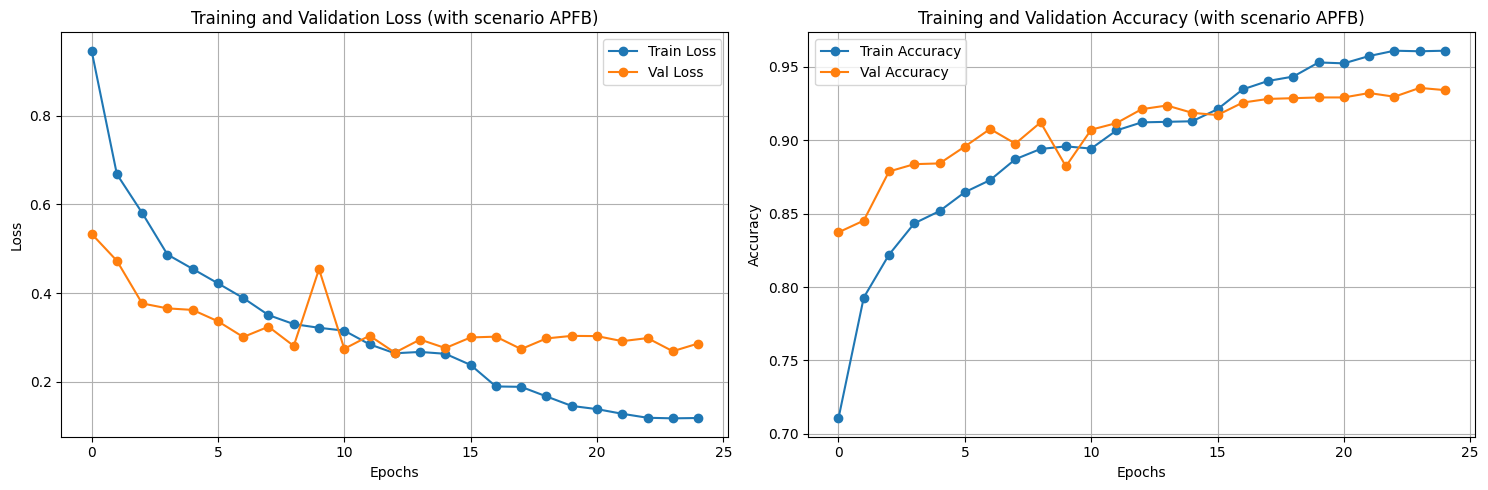

📊 Loading best model for evaluation...
🔄 Running Evaluation with Test Time Augmentation (TTA)...


TTA Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]


📈 Classification Report (with APFB + TTA):
              precision    recall  f1-score   support

         mel       0.89      0.88      0.89       223
          nv       0.95      0.99      0.97      1341
         bkl       0.90      0.80      0.84       220
         bcc       0.93      0.82      0.87       103
       akiec       0.79      0.86      0.82        65
        vasc       0.88      0.82      0.85        28
          df       1.00      0.65      0.79        23

    accuracy                           0.93      2003
   macro avg       0.91      0.83      0.86      2003
weighted avg       0.93      0.93      0.93      2003



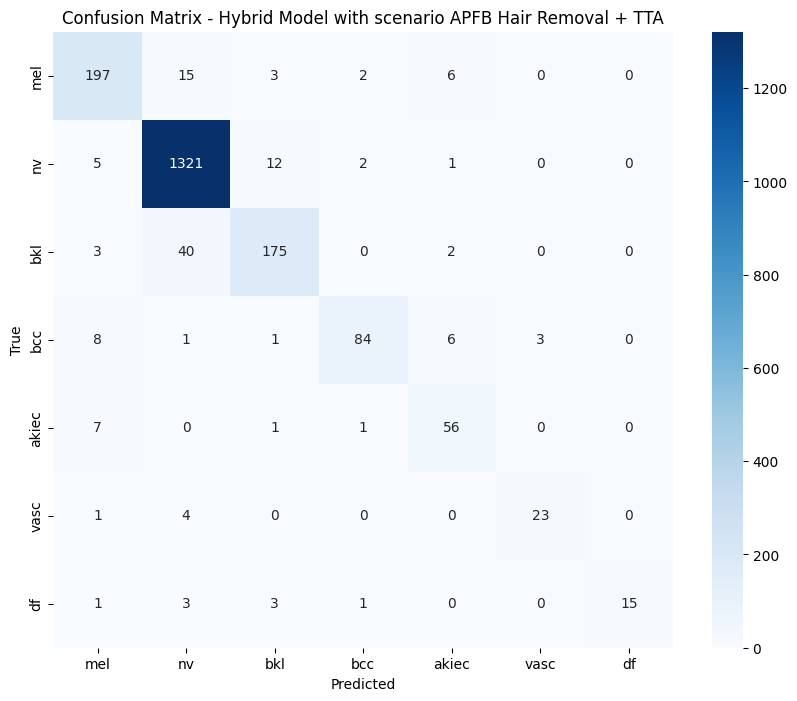


🖼️ Sample Predictions with APFB + TTA (Green=Correct, Red=Wrong):


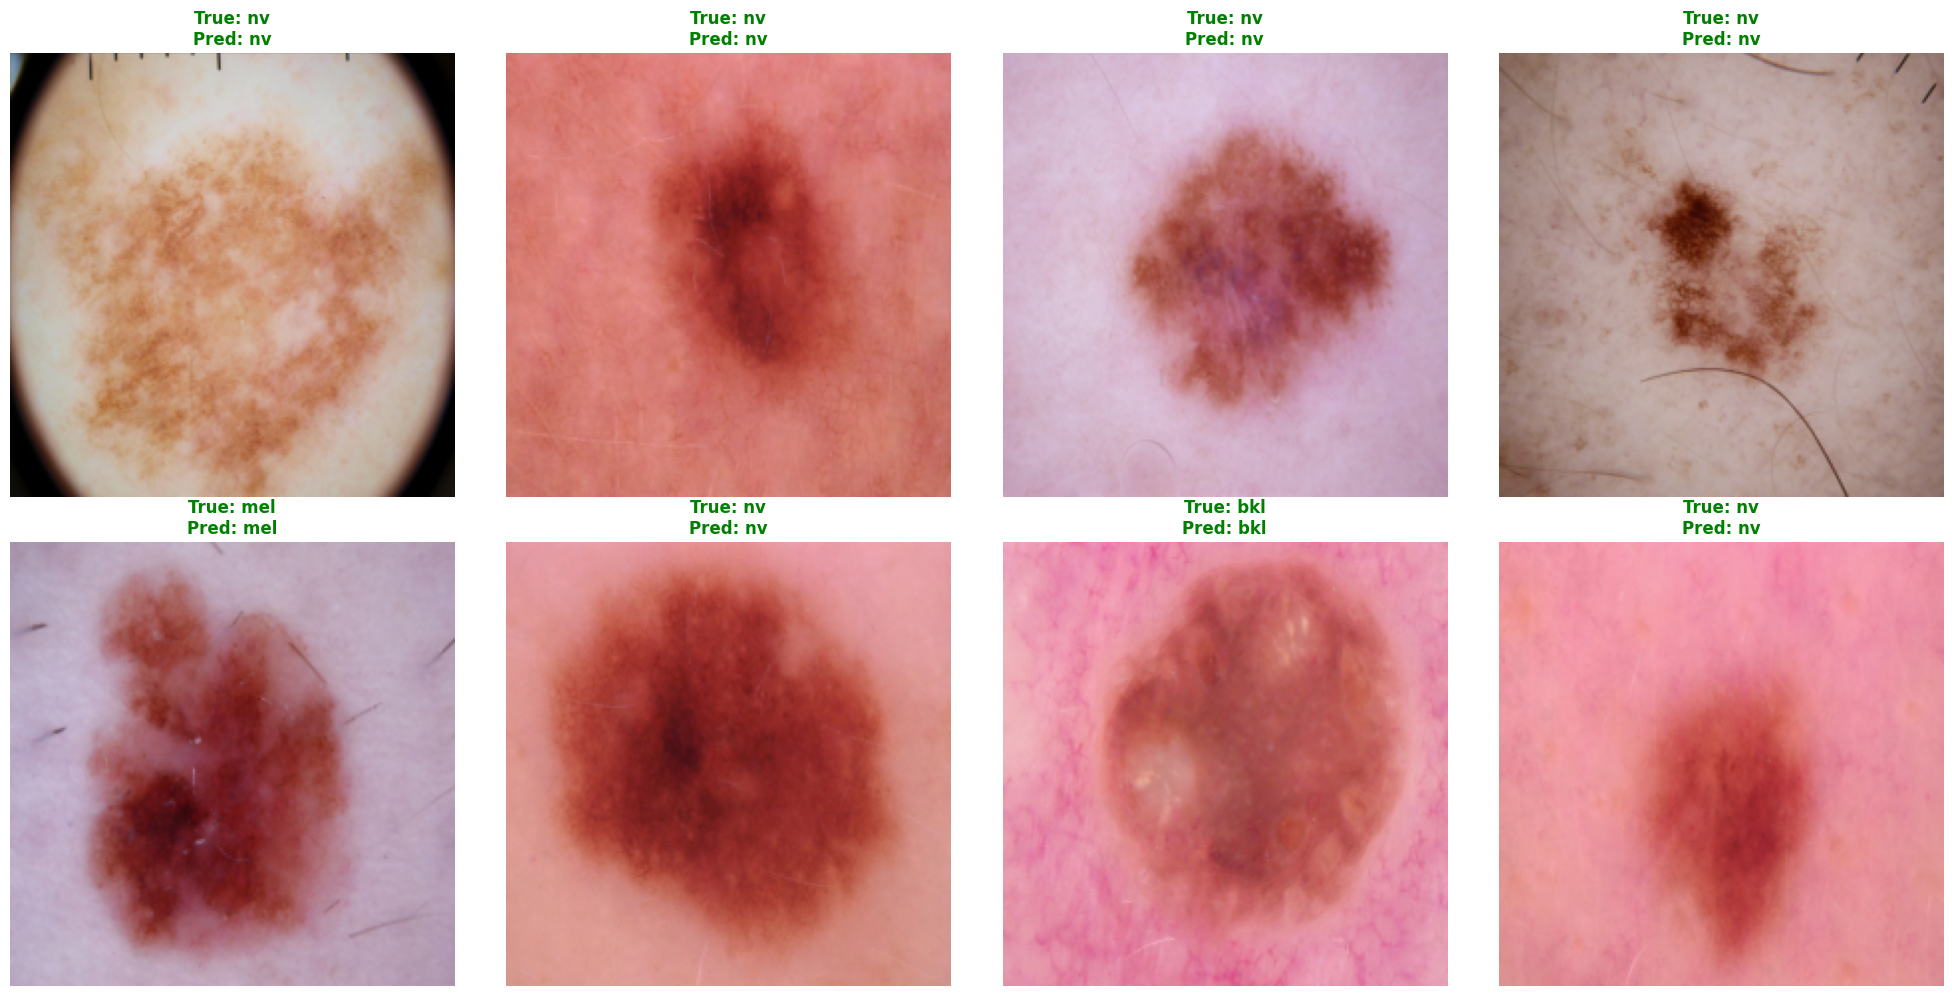

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
💾 Model saved to Google Drive: /content/drive/MyDrive/skin_cancer_hybrid_model_apfb.pth

🎯 Training Complete!
📊 Best Validation Accuracy: 0.9356
💾 Model saved to: /content/drive/MyDrive/skin_cancer_hybrid_model_apfb.pth
🔧 Device used: cuda
🔄 APFB Hair Removal: Enabled
🎯 TTA Evaluation: Enabled


In [ ]:

# Plot training y
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with scenario APFB)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Val Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with scenario APFB)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Load best model and evaluate
print("📊 Loading best model for evaluation...")
model.load_state_dict(torch.load('best_hybrid_model_apfb.pth'))
model.eval()



def evaluate_with_tta(model, dataloader, n_augmentations=3):

    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="TTA Evaluation"):
            imgs, labels = imgs.to(device), labels.to(device)
            batch_predictions = []

            # Original image
            outputs = model(imgs)
            batch_predictions.append(outputs)


            for _ in range(n_augmentations):

                augmented_imgs = torch.flip(imgs, dims=[3])  # Horizontal flip
                outputs_aug = model(augmented_imgs)
                batch_predictions.append(outputs_aug)


            avg_predictions = torch.mean(torch.stack(batch_predictions), dim=0)
            _, preds = torch.max(avg_predictions, 1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred

print("🔄 Running Evaluation with Test Time Augmentation (TTA)...")
y_true, y_pred = evaluate_with_tta(model, val_loader)




print("\n📈 Classification Report (with APFB + TTA):")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Hybrid Model with scenario APFB Hair Removal + TTA')
plt.show()


def display_predictions(model, dataloader, num_samples=8):
    model.eval()
    samples_displayed = 0
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(imgs)):
                if samples_displayed >= num_samples:
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()

                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                true_label = list(label_mapping.keys())[labels[i].item()]
                predicted_label = list(label_mapping.keys())[preds[i].item()]
                is_correct = true_label == predicted_label

                plt.subplot(2, 4, samples_displayed + 1)
                plt.imshow(img)
                color = 'green' if is_correct else 'red'
                plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color, fontweight='bold')
                plt.axis('off')

                samples_displayed += 1

            if samples_displayed >= num_samples:
                break

    plt.tight_layout()
    plt.show()

print("\n🖼️ Sample Predictions with APFB + TTA (Green=Correct, Red=Wrong):")
display_predictions(model, val_loader, num_samples=8)


drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/skin_cancer_hybrid_model_apfb.pth')
print("💾 Model saved to Google Drive: /content/drive/MyDrive/skin_cancer_hybrid_model_apfb.pth")


final_accuracy = max(val_accs) if val_accs else 0
print(f"\n🎯 Training Complete!")
print(f"📊 Best Validation Accuracy: {final_accuracy:.4f}")
print(f"💾 Model saved to: /content/drive/MyDrive/skin_cancer_hybrid_model_apfb.pth")
print(f"🔧 Device used: {device}")
print(f"🔄 APFB Hair Removal: Enabled")
print(f"🎯 TTA Evaluation: Enabled")